# Eclipsing binary: Generate the data

Let's generate an eclipsing binary light curve with `starry`. We are going to use this light curve later in [this notebook](EclipsingBinary_PyMC3.ipynb), [this notebook](EclipsingBinary_Linear.ipynb), and [this notebook](EclipsingBinary_FullSolution.ipynb) to show how to perform inference with `starry`.

The example in this notebook isn't meant to be realistic; rather, it's meant to show the various things we can model with `starry`. Let's begin with the usual imports, and note that we are disabling `lazy` evaluation to keep things simple.

In [19]:
%matplotlib inline

In [20]:
%run notebook_setup.py

<Figure size 1200x400 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import starry

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

First, let's define the maps of the two bodies. For simplicity, we'll place a single large spot on each star. We'll keep the degree of the maps limited to $l = 5$, which is fairly low (you can change this if you'd like!). We'll give the first star an equatorial spot:

In [22]:
map = starry.Map(ydeg=5)
map.add_spot(amp=-0.075, sigma=0.1, lat=0, lon=-30)
A_y = np.array(map.y[1:])

The keywords `amp` and `sigma` control the amplitude and size of the Gaussian expansion of the spot, respectively. The amplitude is measured in the percentage of the luminosity, so this spot corresponds to a decrease in luminosity of 7.5 percent. The standard deviation `sigma` is the (unitless) standard deviation of the Gaussian in $\cos\theta$ on the surface of the star. Here's what this particular spot looks like:

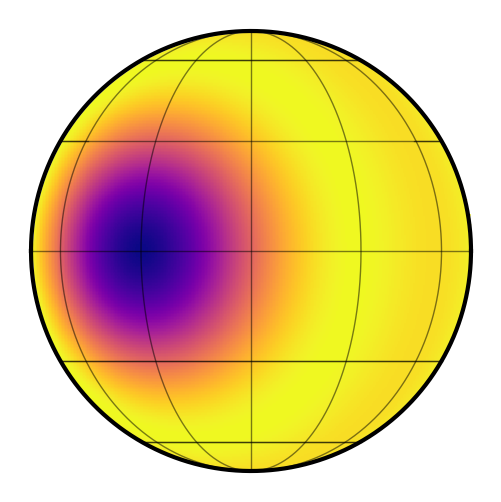

In [23]:
map.show()

Note that we're storing the $l > 0$ coefficients in `A_y` (the $Y_{0,0}$ coefficient is always fixed at unity in `starry`). 

Let's add a similar spot to the secondary, but we'll place it in the southern hemisphere and at a different longitude:

In [24]:
map.reset()
map.add_spot(amp=-0.075, sigma=0.1, lat=-30, lon=60)
B_y = np.array(map.y[1:])

Here's what the secondary looks like:

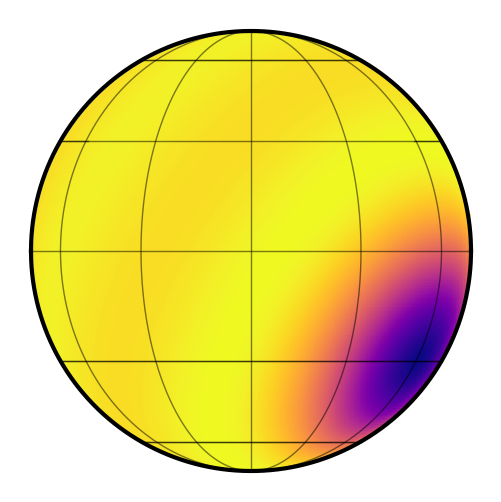

In [25]:
map.show()

Now let's define and store all of the parameters of the system. The primary is a sun-like star. The secondary is a smaller star (say, a K dwarf) on a very short period orbit. To make things interesting, the rotation periods of the primary and secondary are resonant with the orbital period at 5:4 and 5:8, respectively. The equators of both stars are coplanar with the orbit, but the entire system is viewed at an inclination of $80^\circ$. Since the orbital period is so short, both the primary and secondary eclipses are somewhat grazing.

In [26]:
A = dict(
    ydeg=5,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=80.0,  # inclination in degrees
    amp=1.0,  # amplitude (a value prop. to luminosity)
    r=1.0,  #  radius in R_sun
    m=1.0,  # mass in M_sun
    prot=1.25,  # rotational period in days
    u=[0.40, 0.25],  # limb darkening coefficients
    y=A_y,  # the spherical harmonic coefficients
)

B = dict(
    ydeg=5,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc_rot=60.0,  # inclination in degrees
    inc_orb=80.0,  # inclination in degrees
    amp=0.1,  # amplitude (a value prop. to luminosity)
    r=0.7,  #  radius in R_sun
    m=0.7,  #  mass in M_sun
    porb=1.00,  # orbital period in days
    prot=0.625,  # rotational period in days
    t0=0.15,  # reference time in days (when it transits A)
    u=[0.20, 0.05],  # limb darkening coefficients
    y=B_y,  # the spherical harmonic coefficients
)

Finally, let's instantiate the Keplerian system so we can generate a light curve. First we instantiate the primary by calling `starry.Primary`:

In [27]:
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"], amp=A["amp"]),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)
pri.map[1:] = A["u"]
pri.map[1:, :] = A["y"]
pri.map.show(theta=np.linspace(0, 360, 50))

And then the secondary via `starry.Secondary`. Note that we need to specify a few extra parameters for the secondary, such as the orbital period, the reference time, and the orbital inclination (there are other parameters too, such as the eccentricity, which defaults to zero). Importantly, note that we specify the inclination of the secondary **twice**: once within the call to `Map`, and once as a direct keyword to `Secondary`. That's because the former defines the inclination of the rotational axis of the *map* with respect to the plane of the sky, and the secoond defines the inclination of the *orbital plane* with respect to the plane of the sky. For more information on this, see the tutorial on [Orientation](Orientation.ipynb).

In [28]:
sec = starry.Secondary(
    starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B["inc_rot"], amp=B["amp"]),
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"],
    inc=B["inc_orb"],
)
sec.map[1:] = B["u"]
sec.map[1:, :] = B["y"]
sec.map.show(theta=np.linspace(0, 360, 50))

Now we're ready to generate a synthetic light curve. To do this, we instantiate a `System` object:

In [29]:
sys = starry.System(pri, sec)

Sometimes it's useful to check if we defined things correctly by visualizing the system using the `show()` method:

In [30]:
sys.show(t=np.linspace(-2.5, 2.5, 300), window_pad=4.75, figsize=(5, 5))

If we're happy, we can generate a light curve by calling the `flux` method of the `System` object:

In [31]:
t = np.linspace(-2.5, 2.5, 1000)
flux_true = sys.flux(t)
sigma = 0.0005
flux = flux_true + sigma * np.random.randn(len(t))

We're computing the light curve over 5 days. Note that we also added a tiny bit of Gaussian noise to the observation. Let's look at the light curve:

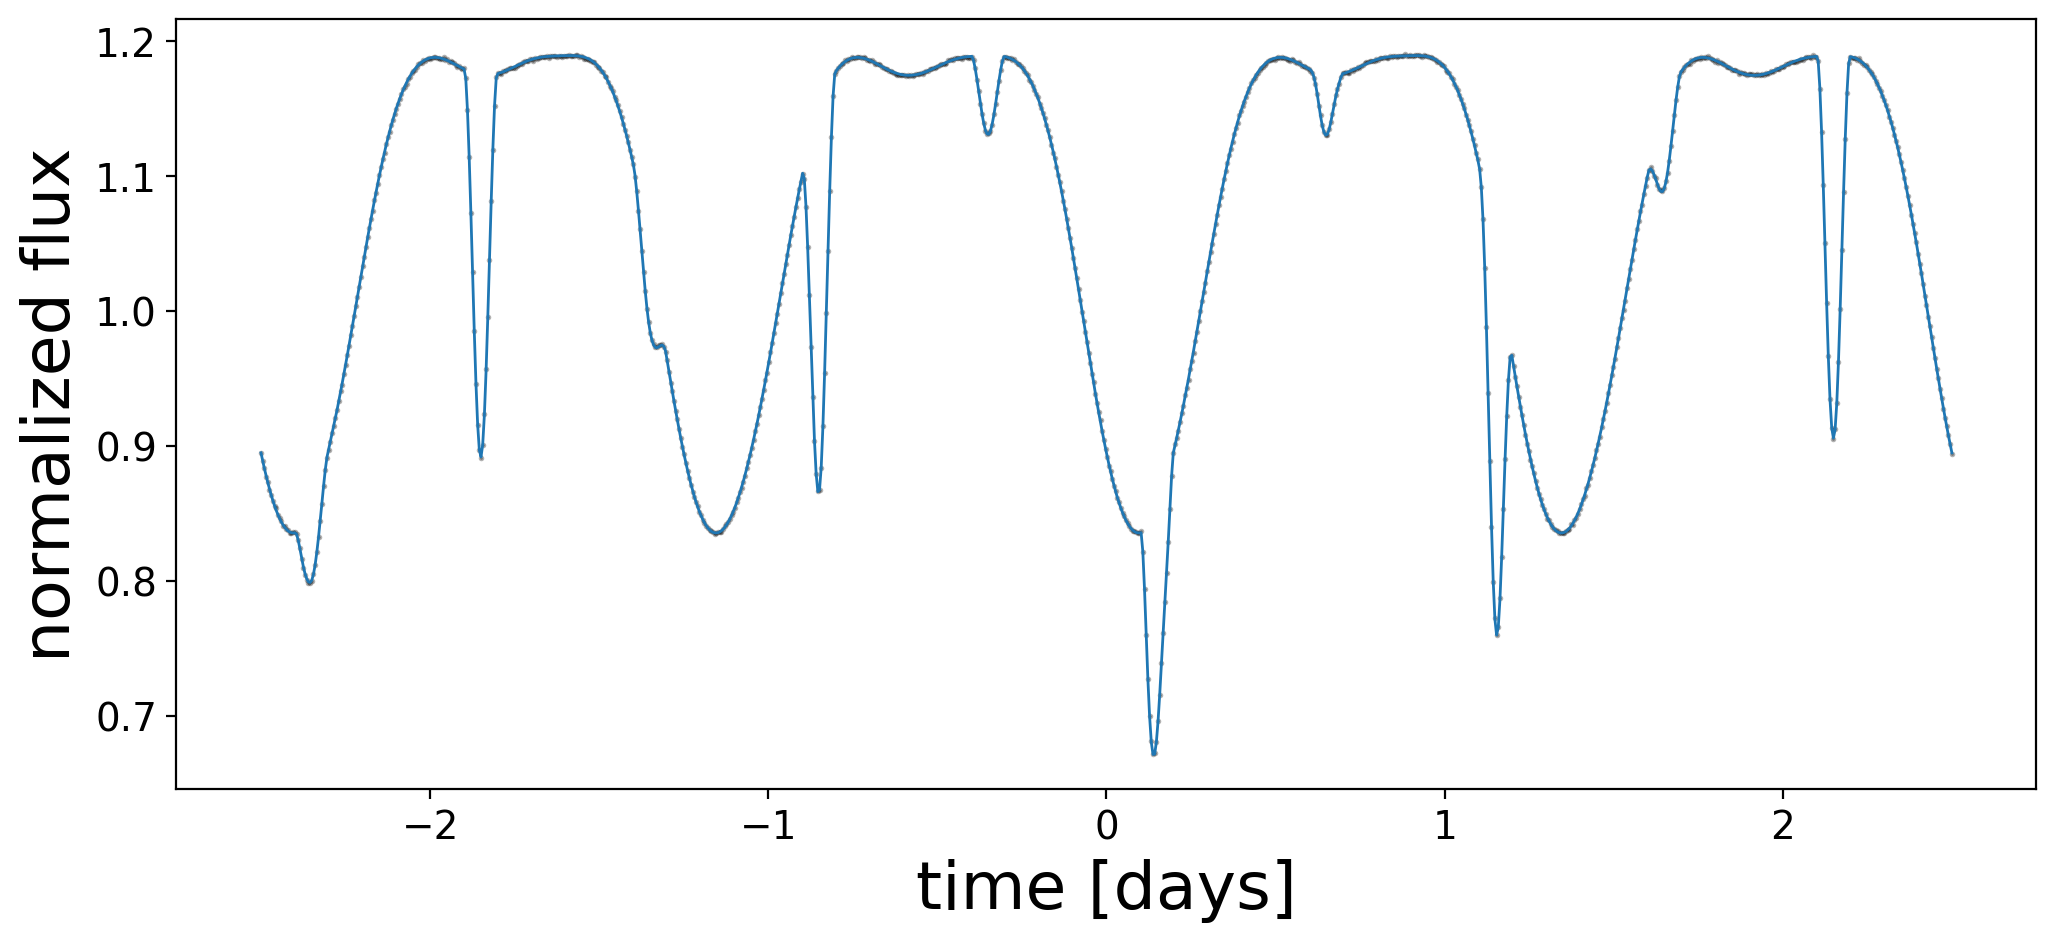

In [32]:
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.3, ms=2)
ax.plot(t, flux_true, lw=1)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

Finally, let's save all of the data so we can do inference later.

In [18]:
np.savez("eb.npz", A=A, B=B, t=t, flux=flux, sigma=sigma)